# Métodos numéricos para la valoración de opciones
Considere la ecuación diferencial estocástica lineal homogénea dada por la ecuación:

$$
    dX_t = \mu X_t dt + \sigma X_t dB_t
$$

Haremos la valoración de opciones para un proceso que sea solución de dicha ecuación

In [23]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.random.seed(123)

**Simulación de trayectoria**

In [2]:
# Parametros
N = 200
dt = 1/250
mu = 0.5
sg = 0.3
B = np.zeros(N)
# Condicion inicial
X0 = 10

In [3]:
B[0] = 0
for i in range(1,N):
    B[i] = B[i-1] - np.sqrt(dt)*np.random.normal()
X = np.zeros(N)
X[0] = X0
for i in range(1,N):
    X[i] = X[i-1] + mu*X[i-1]*dt + sg*X[i-1]*(B[i] - B[i-1])

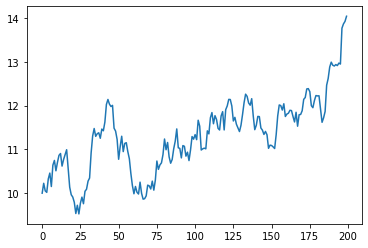

In [4]:
plt.plot(X)
plt.show()

**Estimación de parámetros**

Es necesario comprobar que las hipótesis del método de máxima verosimilitud se cumplen

In [5]:
R = np.zeros(N)
# Retornos instantáneos
for j in range(1,N):
        R[j-1] = (X[j] - X[j-1])/X[j-1]

In [6]:
dt = 1/len(R)
media = np.mean(R)
varianza = np.var(R)
mu = media/dt
sigma = np.sqrt(varianza/dt)
print('mu: '+str(mu)+'\n'+'sigma: '+str(sigma))

mu: 0.37949503253792766
sigma: 0.28235879979836037


**Precio de ejercicio**

Se utiliza simulación montecarlo para encontrar un precio de ejercicio que, en el caso más probable, no suponga una pérdida para el comprador.

In [7]:
k = 10000 # Numero de trayectorias
T = 1 # Periodo de maduración
dt = 1/250
N = 200 # Numero de observaciones
S = np.zeros((k,N))
for i in range(k):
    S[i,0] = X[-1]
for i in range(k):
    for j in range(1,N):
        S[i,j] = S[i, j-1] + mu*S[i, j-1]*dt + sigma*S[i,j-1]*np.sqrt(dt)*np.random.normal()

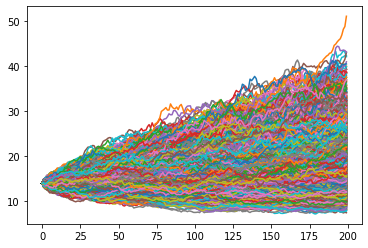

In [8]:
plt.plot(np.matrix(S).T)
plt.show()

In [10]:
K = 9 # Precio de ejercicio

## Fórmula de Black-Scholes

Dado que el modelo proviene de una EDE homogénea, se conoce la solución exacta para la opción dada $r$, la tasa de interés libre de riesgo, $\sigma$, la volatilidad, $K$ el precio de ejercicio, $T$ el tiempo de maduración y $X_0$ la condición inicial (que es, usualmente, el último valor reportado de la trayectoria).

In [11]:
sigma = 0.3
r = 0.05 # La tasa de interes libre de riesgo
S0 = X[-1]
T = 1
d1 = (np.log(S0/K) + (r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)

In [12]:
import scipy.stats as ss
N = ss.norm(0,1)
fcall = S0*N.cdf(d1) - K*np.exp(-r*T)*N.cdf(d2)
print('fcall:', fcall)

fcall: 5.54810184090194


## Simulación Montecarlo

In [13]:
def opcion(x):
    for i in range(1000):
        for j in range(1,200):
            S[i,j] = S[i, j-1] + r*S[i, j-1]*dt + sigma*S[i,j-1]*np.sqrt(dt)*np.random.normal()
    pa = np.zeros(k)
    for i in range(k):
        pa[i] = np.maximum(S[i,-1]-K,0)
    media = np.mean(pa)
    opcion = np.exp(-r*T)*media
    return opcion

In [14]:
from multiprocessing import Pool
p = Pool(100)
yy = p.map(opcion, range(1000))

In [15]:
yy = np.array(yy)
print('media:', np.mean(yy))
print('Minimo:', np.min(yy))
print('Maximo:', np.max(yy))

media: 9.086640866613374
Minimo: 9.072199740525082
Maximo: 9.101066880995923


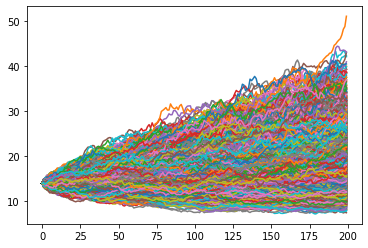

In [16]:
plt.plot(np.matrix(S).T)
plt.show()

## Árboles binomiales

Tenga en cuenta que la convergencia del método se da con valores de $n$ (número de iteraciones) usualmente enre (50-200). Como sea, según las condiciones iniciales, como $\sigma$ o $X_0$ la convergencia puede darse antes o después.

In [27]:
n = 50
dt = T/n
u = np.exp(sigma*np.sqrt(dt)) # Proporción de subida
d = 1/u # Proporción de bajada
p = (np.exp(r*dt)-d)/(u-d) # Probabilidad de salto

In [28]:
f = np.zeros_like(A)
for j in range(n+1):
    f[n,j] = np.maximum(S0*(u**(n-j))*(d**(j)) - K,0)
for i in range(n-1,-1,-1):
    for j in range(i+1):
        f[i,j] = np.exp(-r*dt)*((1-p)*f[i+1,j+1] + (p)*f[i+1,j])
print('opcion', f[0,0])

opcion 0.0676018498542897


## Diferencias finitas

### Parámetros
* El $t_{max} = T$ y el $S_{max} = 2S_0$.
* $\Delta S$, tal que en la malla esté $S_0$.
* $K$ debe estar antes del $S_{max}$


In [24]:
""" Condiciones iniciales
    S_0   : Valor de acción en tiempo actual
    S_max : Cota superior de la acción
    dS    : Tamaño de intervalos del precio
    M     : Intervalos del precio
    T     : Tiempo de muestreo
    N     : Intervalos del tiempo
    dT    : Tamaños de intervalos del tiempo
"""
sigma = 0.3
S0 = 10
K = 1.1*S0
r = 0.05
S_max = 2*S0 
dS = 0.5   
M = int(np.ceil(S_max//dS))
T = 1/12
dT_tmp = (dS/(sigma*S_max))**2
N_tmp = T/dT_tmp
N = int(np.ceil(N_tmp))
dT = T/N;

In [25]:
a = np.zeros(M+1)
b = np.zeros(M+1)
c = np.zeros(M+1)
for j in range(M+1):
    a[j] = (dT/(1+r*dT)) * ((sigma**2 * j**2)/2 - (r * j/2))
    b[j] = (dT/(1+r*dT)) * ((1/dT) - sigma**2 * j**2)
    c[j] = (dT/(1+r*dT)) * ((sigma**2 * j**2)/2 + (r * j/2))

# Crear Malla F
F = np.zeros((N+1, M+1))

# Condiciones de frontera
F[:,0] = 0

for j in range(M):
    F[N, j] = max(j*dS - K, 0)

F[:, M] = S_max - K

for i in reversed(range(N)):
    for j in reversed(range(1, M)):
        F[i,j] = a[j] * F[i+1, j-1] + b[j] * F[i+1, j] + c[j] * F[i+1, j+1]

P = S0//dS;
FF = F[0,int(P)]
print('opción', FF)

opción 0.0632336946173871


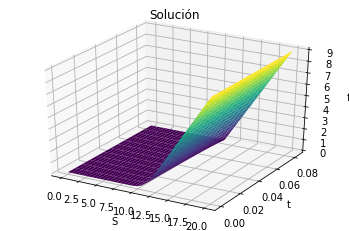

In [26]:
S = np.arange(0, S_max+dS, dS)
t = np.arange(0, T+dT, dT)
X = S
Y = t
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, F, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Solución');
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('f');